In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
# 先reshape变为一维的目的是对每一个像素点进行标准化（让其等价）
# 同时StandardScaler只能对二维的进行标准化
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [4]:
# tf.keras.models.Sequential()
# 这里批归一化为了防止梯度消失；梯度爆炸的例子还没有实践过
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    # 只要在模型中加入下面代码即可
    model.add(keras.layers.BatchNormalization())
    """
    #也可以把激活函数放在批归一化的后面
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [6]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.06473568,  0.06417024,  0.06925011, ..., -0.04180719,
         -0.0820488 , -0.0453927 ],
        [ 0.03996509, -0.02429959, -0.0444834 , ..., -0.02331638,
         -0.01183624,  0.01730926],
        [-0.06179057,  0.04239355, -0.07315566, ..., -0.04179079,
          0.01267072,  0.08045156],
        ...,
        [ 0.04646252,  0.00898979,  0.04762907, ..., -0.06092243,
         -0.01329558,  0.08099216],
        [-0.03193142,  0.04793511, -0.0482423 , ..., -0.04755844,
          0.0592726 , -0.04285277],
        [ 0.00531685, -0.06255622, -0.02170563, ..., -0.02552585,
         -0.01274465,  0.00139575]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [7]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 23s 11ms/step - loss: 1.8274 - accuracy: 0.3932 - val_loss: 1.0250 - val_accuracy: 0.6536
Epoch 2/100
1719/1719 [==============================] - 19s 11ms/step - loss: 1.0984 - accuracy: 0.6155 - val_loss: 0.7807 - val_accuracy: 0.7218
Epoch 3/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.9611 - accuracy: 0.6609 - val_loss: 0.6917 - val_accuracy: 0.7492
Epoch 4/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8809 - accuracy: 0.6888 - val_loss: 0.6533 - val_accuracy: 0.7584
Epoch 5/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.8295 - accuracy: 0.7045 - val_loss: 0.6039 - val_accuracy: 0.7768
Epoch 6/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.7797 - accuracy: 0.7214 - val_loss: 0.5767 - val_accuracy: 0.7988
Epoch 7/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.7505 - accuracy: 0.7343 - val_loss: 0

1719/1719 [==============================] - 19s 11ms/step - loss: 0.3880 - accuracy: 0.8634 - val_loss: 0.3435 - val_accuracy: 0.8768
Epoch 57/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3851 - accuracy: 0.8649 - val_loss: 0.3337 - val_accuracy: 0.8808
Epoch 58/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3815 - accuracy: 0.8658 - val_loss: 0.3410 - val_accuracy: 0.8796
Epoch 59/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3790 - accuracy: 0.8674 - val_loss: 0.3461 - val_accuracy: 0.8750
Epoch 60/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3745 - accuracy: 0.8695 - val_loss: 0.3387 - val_accuracy: 0.8796
Epoch 61/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3724 - accuracy: 0.8682 - val_loss: 0.3398 - val_accuracy: 0.8806
Epoch 62/100
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3687 - accuracy: 0.8705 - val_loss: 0.3355 

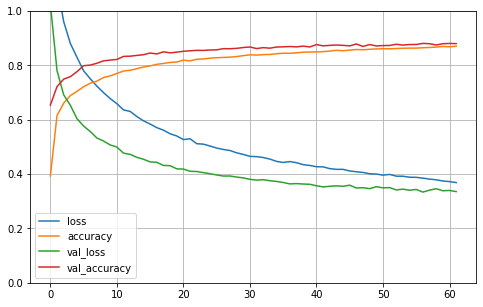

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
# 批归一化缓解梯度消失

In [9]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.37084853649139404, 0.8680999875068665]